In [1]:
from model.GP_model import GP
import numpy as np
from matplotlib import pyplot as plt
import polars as pl

/home/anfchen/projects/plant-rl/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:2025-12-01 12:19:31,830:jax._src.xla_bridge:477: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/anfchen/projects/plant-rl/.venv/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 475, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/anfchen/projects/plant-rl/.venv/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/anfchen/projects/plant-rl/.venv/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_dev

In [4]:
# load polars dataset (provided by Steven)
df = pl.read_parquet("GP_data/cleaned_offline_dataset_daily_continuous_v11.parquet")

# move action traces forward one step
df = df.with_columns(
    pl.col("time").shift(1).over("experiment", "zone", "plant_id").alias("last_time"),
)

df = df.with_columns(
    (
        pl.col("last_time").is_not_null()
        & (pl.col("last_time") == pl.col("time") - pl.duration(days=1))
    ).alias("has_yesterday")
)

df = df.drop("last_time")

for color in ['red', 'white', 'blue']:
    df = df.with_columns(
        pl.col(color + "_coef_trace_0.5")
        .shift(1)
        .over("experiment", "zone", "plant_id")
        .alias("last_" + color + "_coef_trace_0.5"),
    )
    
    df = df.with_columns(
        pl.when(~pl.col("has_yesterday"))
        .then(pl.lit(0))
        .otherwise(pl.col("last_" + color + "_coef_trace_0.5"))
        .alias("last_" + color + "_coef_trace_0.5")
    )

df = df.drop("has_yesterday")

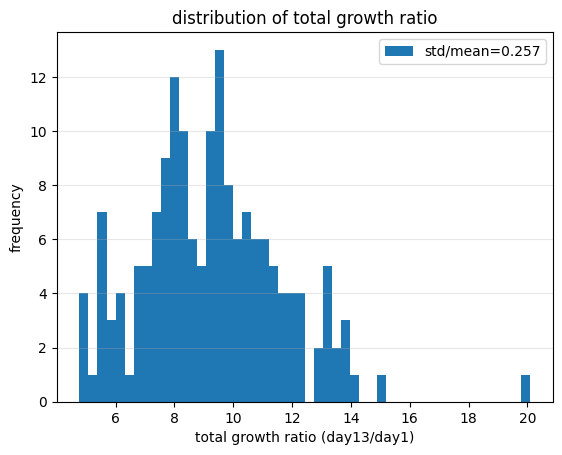

In [ ]:
# (Optional) Plot the distribution of total growth ratios
'''
result = (
    df.filter(pl.col("day").is_in([1, 13]))
    .sort("day")
    .group_by("experiment", "zone", "plant_id")
    .agg(
        (pl.col("clean_area").last() / pl.col("clean_area").first()).alias("growth")
    )
)
result = result.filter(pl.col("growth") != 1)
plt.hist(result['growth'], bins=50, label=f'std/mean={result["growth"].std()/result["growth"].mean():.3f}')
plt.xlabel("total growth ratio (day13/day1)")
plt.ylabel("frequency")
plt.title("distribution of total growth ratio")
plt.grid(axis='y', alpha=0.3)
plt.legend()
'''

In [5]:
df = df.with_columns(
    pl.col("clean_area")
    .shift(-1)
    .over("experiment", "zone", "plant_id")
    .alias("next_clean_area"),
)

df = df.filter(pl.col("truncated") == False)
df = df.filter(pl.col("terminal") == False)
df = df.filter(pl.col("is_good_day") == True)
df = df.filter(pl.col("next_clean_area").is_not_null())

In [6]:
# split training and validation data
val_set = []

train_df = df.filter((~(pl.col("zone").is_in(val_set)) & (pl.col("experiment") == 13)))
val_df = df.filter((pl.col("zone").is_in(val_set)) & (pl.col("experiment") == 13))

In [7]:
train_input_data = np.vstack(
    list(
        zip(
            train_df["day"].to_list(),
            train_df["clean_area"].to_list(),
            train_df["last_red_coef_trace_0.5"].to_list(),
            train_df["last_white_coef_trace_0.5"].to_list(),
            train_df["last_blue_coef_trace_0.5"].to_list(),
            train_df["red_coef"].to_list(),
            train_df["white_coef"].to_list(),
            train_df["blue_coef"].to_list()
        )
    )
)

train_output_data = np.vstack(train_df["next_clean_area"].to_list()) / np.vstack(train_df["clean_area"].to_list())

len(train_output_data)

2194

In [8]:
GP_model = GP(train_input_data, train_output_data)  # , kernel = gpx.kernels.RBF())

Optimization terminated successfully.
         Current function value: 2603.283109
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15


In [ ]:
import pickle

with open(
    f"models/vulcan_E13only_every_day+size_1day_trace5_ratio.pickle", "wb"
    ) as f:
    pickle.dump(GP_model, f)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

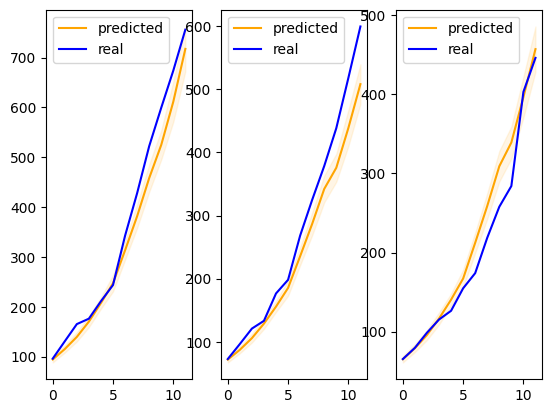

In [ ]:
fig, ax = plt.subplots(1, 3)
for plant_id in range(3):
    # get subset of val_df with plant_id
    this_val_df = val_df.filter(pl.col("plant_id") == plant_id+3)
    input_data = np.vstack(
        list(
            zip(
                this_val_df["day"].to_list(),
                this_val_df["clean_area"].to_list(),
                this_val_df["red_coef"].to_list(),
                this_val_df["white_coef"].to_list(),
                this_val_df["blue_coef"].to_list(),
                this_val_df["last_red_coef_trace_0.5"].to_list(),
                this_val_df["last_white_coef_trace_0.5"].to_list(),
                this_val_df["last_blue_coef_trace_0.5"].to_list(),
            )
        )
    )
    output_data = np.vstack(this_val_df["next_clean_area"].to_list())
    MEAN = []
    STD = []
    current_area = input_data[0][1]
    for i in range(len(output_data)):
        input = np.hstack([[input_data[i][0], current_area], input_data[i][2:]])
        predictive_mean, predictive_std = GP_model.predict_mean_std(np.vstack([input]))
        MEAN.append(current_area * predictive_mean[0])
        STD.append(current_area * predictive_std[0])
        current_area *= predictive_mean[0]

    MEAN = np.array(MEAN)
    STD = np.array(STD)

    ax[plant_id].plot(MEAN, color="orange", label="predicted")
    ax[plant_id].fill_between(
        np.arange(len(output_data)),
        MEAN - 1 * STD,
        MEAN + 1 * STD,
        alpha=0.1,
        color="orange",
    )
    ax[plant_id].plot(output_data, color="blue", label="real")

    ax[plant_id].legend()

In [ ]:
break

In [ ]:
actions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
test_area = np.linspace(0, 1000, 100)
tests = [
    np.vstack([[area] + actions[i] + [0.33, 0.33, 0.33] for area in test_area])
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


/tmp/ipykernel_3230/2951416745.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


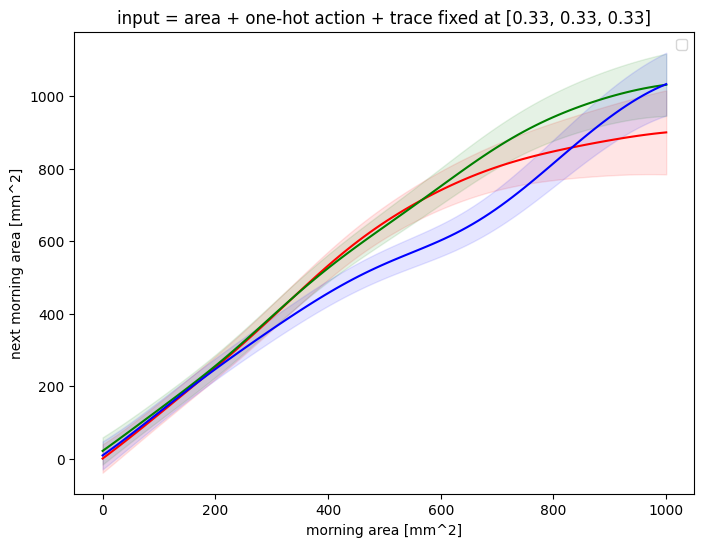

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
COLORS = ["r", "g", "b"]
for i in range(3):
    ax.plot(test_area, Mean[i], color=COLORS[i])
    ax.fill_between(
        test_area.squeeze(),
        Mean[i] - 1 * Std[i],
        Mean[i] + 1 * Std[i],
        alpha=0.1,
        color=COLORS[i],
    )
ax.set_xlabel("morning area [mm^2]")
ax.set_ylabel("next morning area [mm^2]")
ax.set_title(f"input = area + one-hot action + trace fixed at [0.33, 0.33, 0.33]")
# ax.set_title(f"input = area + one-hot action ")
ax.legend()
# ax.set_xlim([100, 1000])
# ax.set_ylim([100., 750])